In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect,MetaData, Table,Column, Integer, String, Float
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
meta = MetaData(engine)
Base = automap_base(bind=engine, metadata=meta)

# reflect the tables
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [6]:
#Create our session
Measurements, Stations = Base.classes.measurement, Base.classes.station
session = Session(engine)
Base.metadata.create_all(engine)
date = session.query(Measurements.date).order_by(Measurements.date).all()
last_date = date[-1][0]
print(last_date)

2017-08-23


# Exploratory Climate Analysis

In [7]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)
# Perform a query to retrieve the data and precipitation scores
last_year_prec = session.query(Measurements.date,Measurements.prcp).filter(Measurements.date >= last_year).\
     order_by(Measurements.date).all()
print(len(last_year_prec))
# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date
df_lastyear = pd.DataFrame([(d.date, d.prcp) for d in last_year_prec], 
                  columns=['Date', 'Prcp'])

df_lastyear.set_index('Date',inplace=True)

2016-08-23
2230


In [8]:
df_lastyear.describe(include = 'all')

,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


<IPython.core.display.Javascript object>


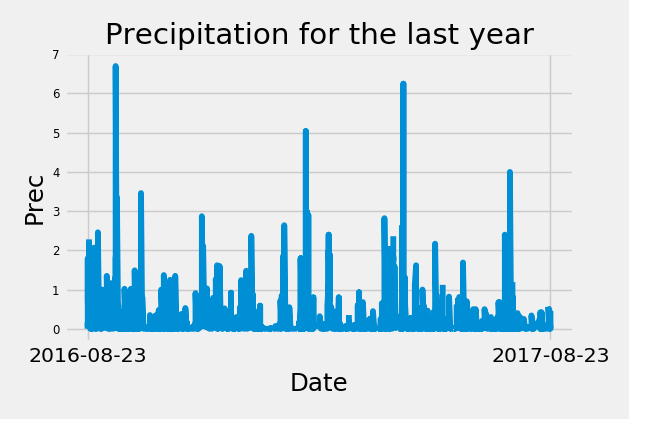

In [9]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.dates as mdates
import numpy as np

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(df_lastyear.index, df_lastyear.Prcp)
ax.set_title("Precipitation for the last year")
ax.tick_params(axis = 'y', which = 'major', labelsize = 8)

my_xticks = ax.get_xticks()
plt.xticks([my_xticks[0], my_xticks[-1]],[df_lastyear.index[0],df_lastyear.index[-1]], visible=True, rotation="horizontal")

plt.xlabel('Date')
plt.ylabel('Prec')
plt.tight_layout()
plt.show()

In [10]:
stations = session.query(Stations.station).all()
stations

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [11]:
# How many stations are available in this dataset?
station_count= session.query(Measurements.tobs,Measurements.station).order_by(Measurements.date).all()
df_stations = pd.DataFrame([(d.tobs, d.station) for d in station_count], 
                  columns=['Temp', 'Station'])

df_stations.head()
df_stations['Station'].nunique()

9

In [12]:
# What are the most active stations?
# List the stations and the counts in descending order.
station_count = df_stations.groupby('Station').count()
station_sort = station_count.sort_values( 'Temp',ascending=False)
station_sort

,Temp
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest = session.query(Measurements.station, func.min(Measurements.tobs)).all()
highest = session.query(Measurements.station, func.max(Measurements.tobs)).all()
avg = session.query(Measurements.station, func.avg(Measurements.tobs)).filter(Measurements.station == station_sort.index[0]).all()
print(lowest,highest,avg)

[('USC00511918', 53.0)] [('USC00519397', 87.0)] [('USC00519281', 71.66378066378067)]


In [14]:
# Choose the station with the highest number of temperature observations.
highest_station = session.query(Measurements.tobs, func.count(Measurements.tobs)).group_by(Measurements.tobs).filter(Measurements.date >= last_year).filter(Measurements.station=='USC00519281').all()
highest_station_df = pd.DataFrame([(d[0], d[1]) for d in highest_station], 
                  columns=['Temp', 'Freq'])
highest_station_sort = highest_station_df.sort_values( 'Temp',ascending=True)
#highest_station_df.set_index('Temp',inplace=True)
highest_station_df

,Temp,Freq
0,59.0,3
1,60.0,2
2,61.0,1
3,62.0,6
4,63.0,4
5,64.0,3
6,65.0,7
7,66.0,5
8,67.0,15
9,68.0,12


<IPython.core.display.Javascript object>


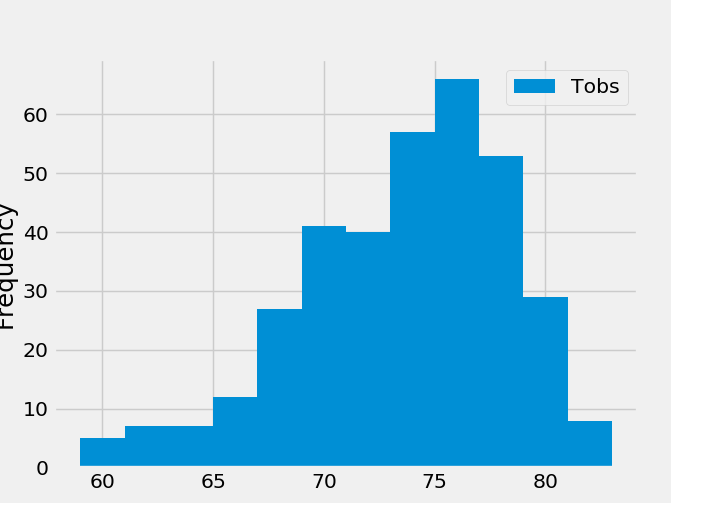

In [15]:
highest_station = session.query(Measurements.tobs).filter(Measurements.date >= last_year).filter(Measurements.station=='USC00519281').all()
highest_station = pd.DataFrame([d[0] for d in highest_station], columns=['Tobs'])
highest_station.plot.hist(by='Temp',bins=12)
plt.show()

In [16]:
# This function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
v = (calc_temps('2017-03-01', '2017-03-15'))
v

[(62.0, 71.1086956521739, 82.0)]

<IPython.core.display.Javascript object>


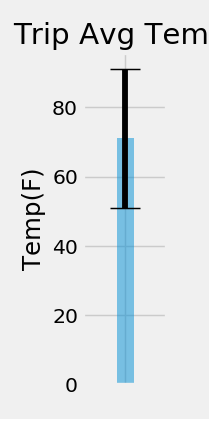

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = v[0][2]-v[0][0]
fig, ax = plt.subplots(figsize=(2,4))
ax.bar(1,v[0][1], yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10,width=0.2)
ax.set_xlim(0.5, 1.5)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False) 
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp ')
plt.tight_layout()
plt.show()

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_prec = session.query(Stations.name,Stations.station,Stations.latitude,Stations.longitude,Stations.elevation, func.avg(Measurements.prcp)).group_by(Stations.station).filter(Measurements.date >= '2017-03-01').filter(Measurements.date <= '2017-03-15').filter(Stations.station == Measurements.station).order_by(func.avg(Measurements.prcp).desc()).all()
station_prec

[('PEARL CITY, HI US',
  'USC00517948',
  21.3934,
  -157.9751,
  11.9,
  0.4342857142857143),
 ('KANEOHE 838.1, HI US', 'USC00513117', 21.4234, -157.8015, 14.6, 0.384),
 ('WAIHEE 837.5, HI US',
  'USC00519281',
  21.45167,
  -157.84888999999998,
  32.9,
  0.364),
 ('MANOA LYON ARBO 785.2, HI US',
  'USC00516128',
  21.3331,
  -157.8025,
  152.4,
  0.2692307692307692),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'USC00514830',
  21.5213,
  -157.8374,
  7.0,
  0.25),
 ('WAIMANALO EXPERIMENTAL FARM, HI US',
  'USC00519523',
  21.33556,
  -157.71139,
  19.5,
  0.23199999999999998),
 ('WAIKIKI 717.2, HI US',
  'USC00519397',
  21.2716,
  -157.8168,
  3.0,
  0.18266666666666664)]

# Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurements.date) == date).all()
 
    
daily_normals('03-15')

[(58.0, 68.54716981132076, 76.0)]

In [21]:
from flask import jsonify
def start(start_date):
    
    start = session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).all()
    for record in start:
        (tmin, tave, tmax) = record
        print(tmin)
        print(tave)
        print(tmax)
        # (min_temp=tmin,ave_temp=tave,max_temp=tmax)
start('08-27')

53.0
73.09795396419437
87.0


In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
vd =[]
d1 = dt.datetime.strptime('03-1-2017', "%m-%d-%Y")

d2 = dt.datetime.strptime('03-15-2017', "%m-%d-%Y")
   
date_generated = [d2 - dt.timedelta(days=x) for x in range(0, 15)]

for date in date_generated:
     vd.append(date.strftime("%m-%d"))
print(vd)

for d in vd:
    dn = daily_normals(d)
    normals.append(dn[0])
print(normals)

['03-15', '03-14', '03-13', '03-12', '03-11', '03-10', '03-09', '03-08', '03-07', '03-06', '03-05', '03-04', '03-03', '03-02', '03-01']
[(58.0, 68.54716981132076, 76.0), (62.0, 70.32758620689656, 77.0), (56.0, 69.29629629629629, 77.0), (62.0, 69.88888888888889, 80.0), (60.0, 69.89285714285714, 82.0), (57.0, 69.12280701754386, 75.0), (57.0, 68.56140350877193, 75.0), (59.0, 68.72413793103448, 78.0), (60.0, 69.17241379310344, 78.0), (60.0, 69.20338983050847, 76.0), (60.0, 67.89090909090909, 76.0), (57.0, 69.27272727272727, 77.0), (60.0, 70.06896551724138, 78.0), (61.0, 70.36666666666666, 78.0), (64.0, 70.0327868852459, 76.0)]


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_v = pd.DataFrame([(d[0],d[1],d[2]) for d in normals], 
                  columns=['tmin', 'tave','tmax'])
df_v['Date']=vd
df_v['Date'].to_string
df_v.set_index('Date',inplace=True)
df_v

,tmin,tave,tmax
Date,,,
03-15,58.0,68.547170,76.0
03-14,62.0,70.327586,77.0
03-13,56.0,69.296296,77.0
03-12,62.0,69.888889,80.0
03-11,60.0,69.892857,82.0
03-10,57.0,69.122807,75.0
03-09,57.0,68.561404,75.0
03-08,59.0,68.724138,78.0
03-07,60.0,69.172414,78.0


<IPython.core.display.Javascript object>


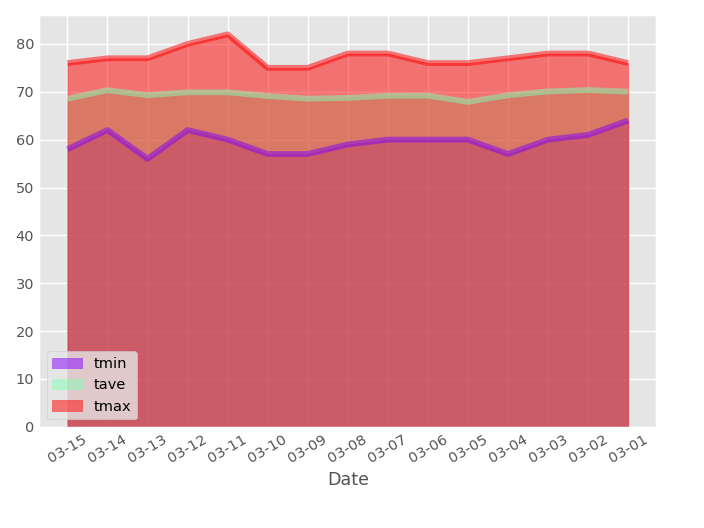

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
plt.style.use('ggplot')
df_v.plot(kind='area', stacked=False, alpha=0.5, colormap='rainbow')
plt.xticks(range(len(vd)), vd,rotation=30)
plt.xlabel('Date')
[ax.legend(loc=0) for ax in plt.gcf().axes]
plt.tight_layout()
plt.show()